In [1]:
%load_ext autoreload
%autoreload 2

## Импорт библиотек

In [2]:
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode()

In [38]:
import os
import sys
import re
import string
import pandas as pd
import numpy as np

import plotly.express as px
import json
from qdrant_client.models import Distance, VectorParams, SearchParams
from qdrant_client import QdrantClient
from rich.progress import track
from qdrant_client.models import PointStruct

from sentence_transformers import SentenceTransformer
sys.path.append(os.path.pardir)

from project_consts import PROJECT_ROOT

In [4]:
FILE_NAME = "intents_chat_bot_pervaya_lin-1000067115-HTA.json"
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", FILE_NAME)
PROCESSED_FOLDER_PATH = os.path.join(PROJECT_ROOT, "data", "processed")

## Получение данных

In [5]:
intents_df  = pd.read_json(os.path.join(PROCESSED_FOLDER_PATH, 'intents_prepared.json'))
intents_df.head()

intent_id                     intent_path  \
0   24174474  /Пересекающиеся/Продлить полис   
1   24174474  /Пересекающиеся/Продлить полис   
2   24174474  /Пересекающиеся/Продлить полис   
3   24174474  /Пересекающиеся/Продлить полис   
4   24174474  /Пересекающиеся/Продлить полис   

                                         phrase  
0                          продлить полис осаго  
1                      мне нужно продлить полис  
2          нам нужно продлить полис страхования  
3  каким образом я могу продлить полис осаго от  
4                   помогите продлить страховку

In [66]:
len(intents_df.intent_path.unique())

183

### Визуализация

In [88]:
def visualize_dist(df, column_name):
    fig = px.histogram(df, y=column_name).update_yaxes(categoryorder='total ascending')
    fig.update_layout(
        autosize=False,
        height=5000,
        showlegend=True
    )
    fig.update_yaxes(type='category', tickvals=df[column_name].tolist())
    fig.show()

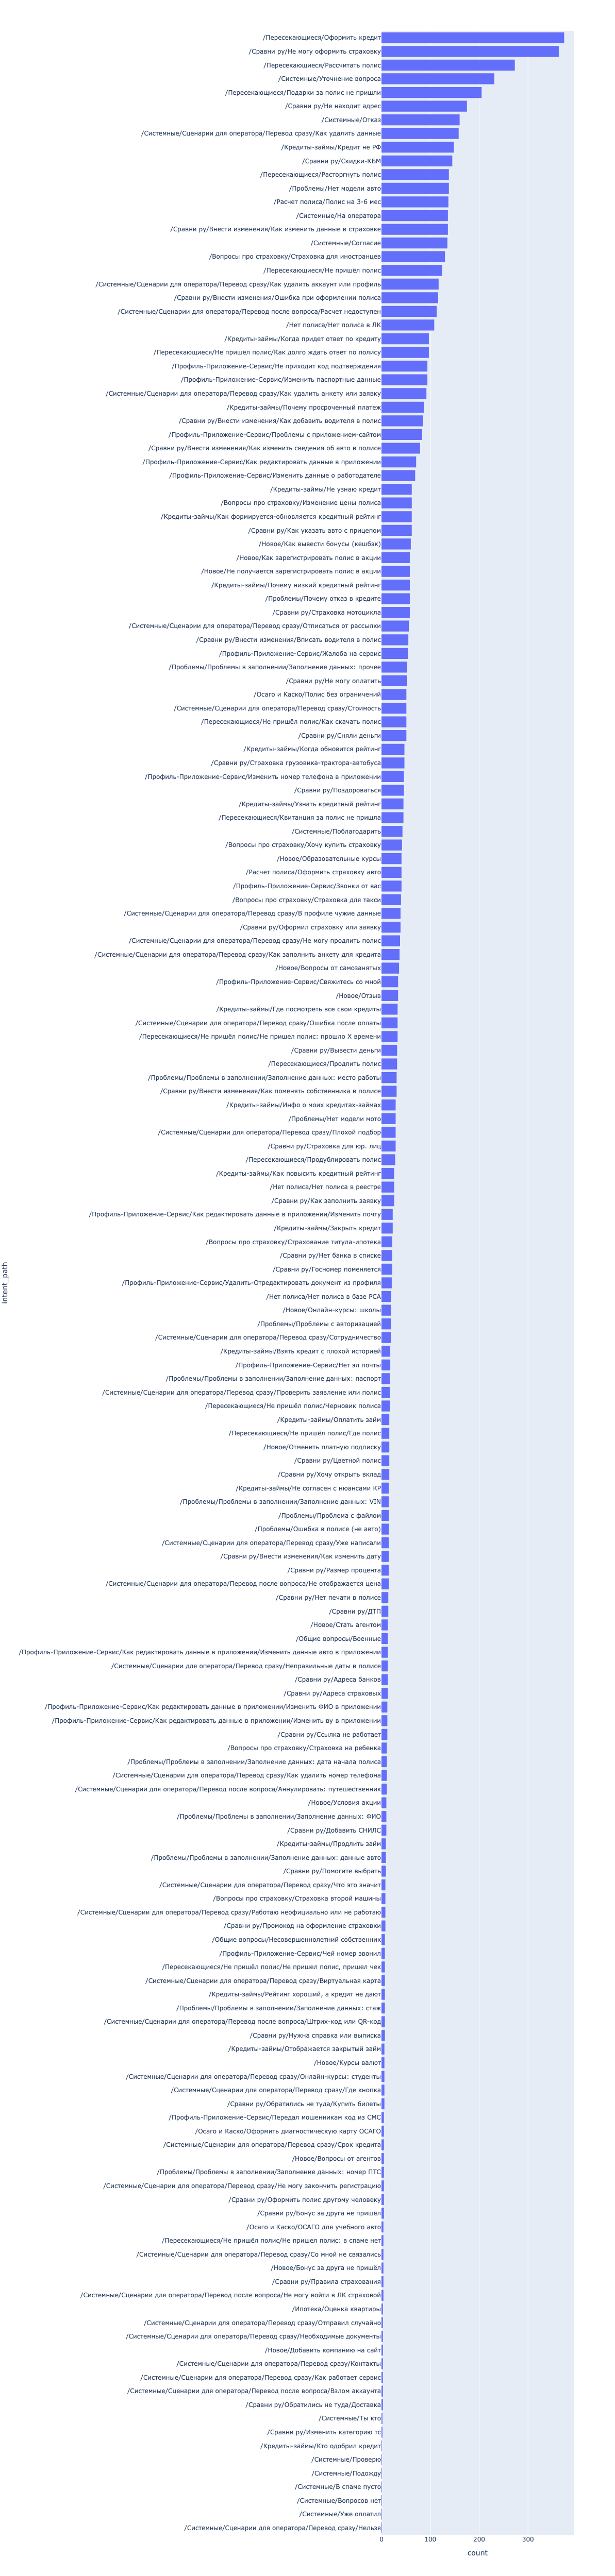

In [89]:
visualize_dist(intents_df, 'intent_path')

##  Векторизация

In [122]:
model = SentenceTransformer('sentence-transformers/LaBSE', cache_folder='./hfmodels')

In [17]:
client = QdrantClient(url="http://localhost:6333")
client.create_collection(
    collection_name="intents_collection",
    vectors_config=VectorParams(size=model.get_sentence_embedding_dimension(), distance=Distance.COSINE),
)


True

##  Векторизация

In [18]:
client.upload_points(
collection_name="intents_collection",
points=[
    PointStruct(
        id=idx, vector=model.encode(row['phrase']), payload={'intent_path': row['intent_path']}
    )
    for idx, row in track(intents_df.iterrows(), description="Upload emb to qdrant...", total=len(intents_df))
])

Output()

##  Поиск интентов

In [123]:
import pandas as pd


VALIDATION_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", 'sravni_dataset.xlsx')
validation_df = pd.read_excel(VALIDATION_DATA_PATH)
validation_df.head(5)

testCase                                            comment  \
0         1  /Системные/Сценарии для оператора/Перевод сраз...   
1         2          /Кредиты-займы/Почему просроченный платеж   
2         3  /Сравни ру/Внести изменения/Как изменить сведе...   
3         4                    /Пересекающиеся/Не пришёл полис   
4         5                      /Кредиты-займы/Закрыть кредит   

                                             request  expectedResponse  \
0  Прошу убрать из рассылок любого характера мой ...               NaN   
1  Здравствуйте. Я брал займ в мфо через приложен...               NaN   
2  Добрый день. Я оформила полис ОСАГО на вашем с...               NaN   
3  Два дня назад оплатил осаго, через сравни ру д...               NaN   
4  Здравствуйте, я через вас взял займ в миг кред...               NaN   

                           expectedState  skip  preActions  
0  /Сценарии для оператора Перевод сразу   NaN         NaN  
1                   /ChatWithOperatorMfo   NaN         NaN  
2              /Внесение изменений/Полис   NaN         NaN  
3                       /Не пришёл полис   NaN         NaN  
4                   /ChatWithOperatorMfo   NaN         NaN

In [125]:
len(validation_df)

650

In [126]:
validation_df['comment'] = validation_df['comment'].apply(lambda x: x.strip())

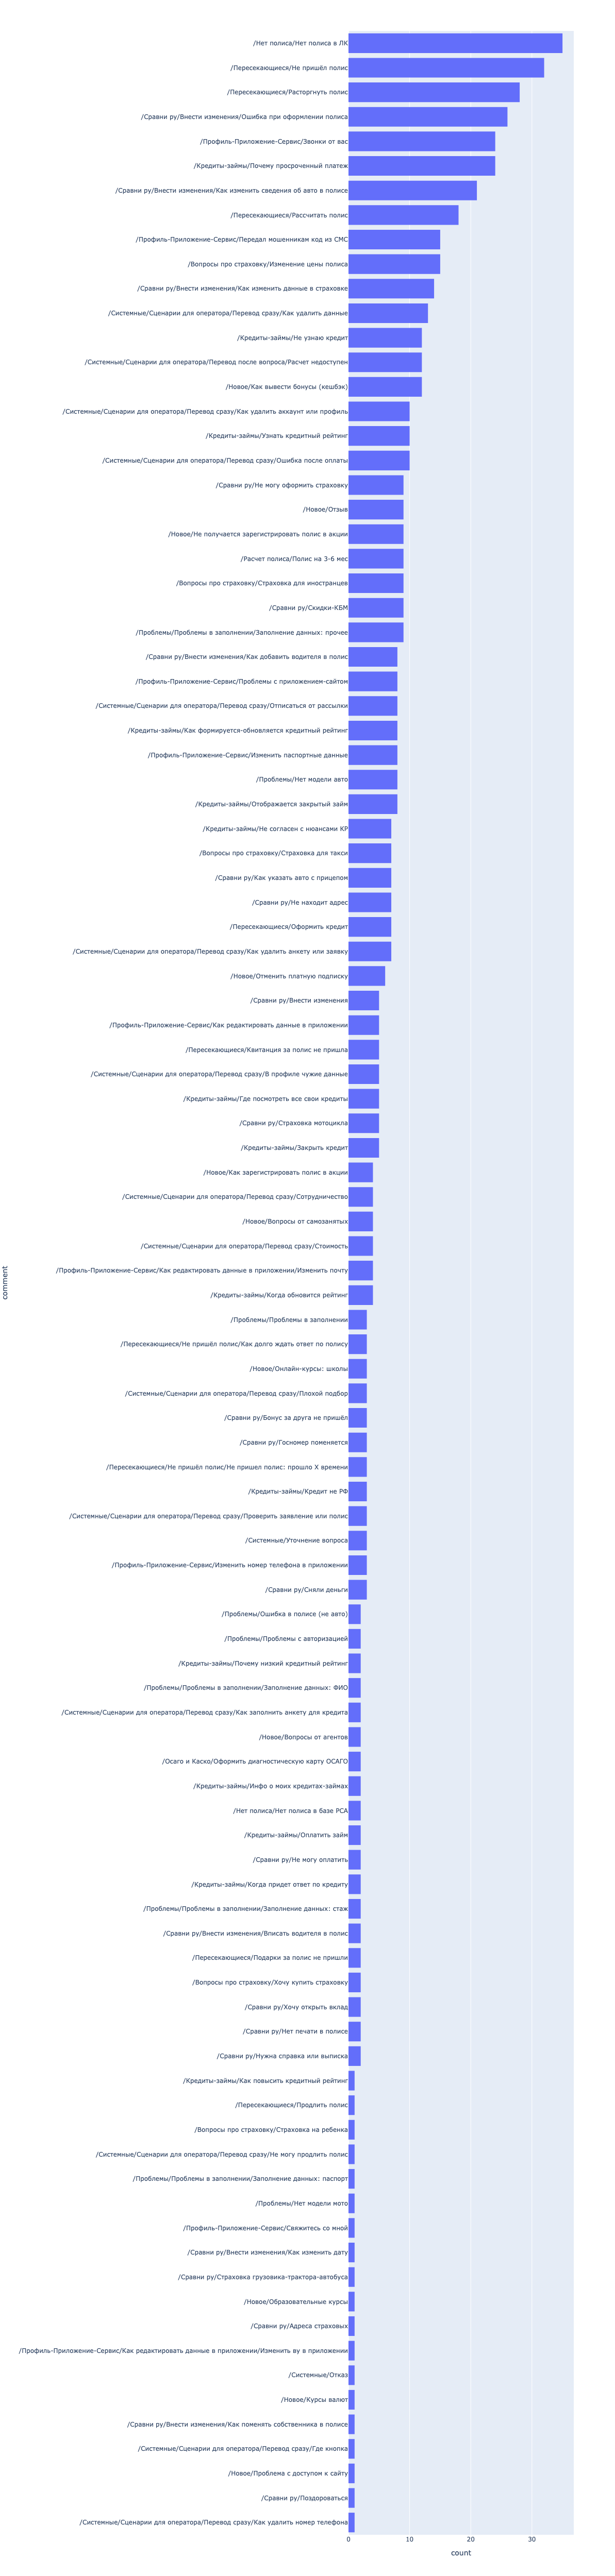

In [127]:
visualize_dist(validation_df, 'comment')

In [128]:
class VectorClassifier:
    def __init__(self, vector_model, vector_store):
        self._vector_model = vector_model
        self._vector_store = vector_store

    def classify(self, text, k=5) -> str:
        embedding = self._vector_model.encode(text)
        #find top 5
    
        knn_result = self._vector_store.search(
            collection_name="intents_collection",
            query_vector=embedding,
            limit=1,
            search_params=SearchParams(
                exact=True,  # Turns on the exact search mode
            ),
        )[0]
        
        return knn_result.payload.get('intent_path'), knn_result.score

In [129]:
classifier = VectorClassifier(vector_model = model, vector_store=client)
classifier.classify(validation_df.iloc[0]['request'])

('/Системные/Сценарии для оператора/Перевод сразу/Отписаться от рассылки',
 0.7035542)

In [130]:
validation_df['model_predict'] = validation_df.apply(lambda x: classifier.classify(x['request'])[0], axis=1)

In [131]:
validation_df.head()

testCase                                            comment  \
0         1  /Системные/Сценарии для оператора/Перевод сраз...   
1         2          /Кредиты-займы/Почему просроченный платеж   
2         3  /Сравни ру/Внести изменения/Как изменить сведе...   
3         4                    /Пересекающиеся/Не пришёл полис   
4         5                      /Кредиты-займы/Закрыть кредит   

                                             request  expectedResponse  \
0  Прошу убрать из рассылок любого характера мой ...               NaN   
1  Здравствуйте. Я брал займ в мфо через приложен...               NaN   
2  Добрый день. Я оформила полис ОСАГО на вашем с...               NaN   
3  Два дня назад оплатил осаго, через сравни ру д...               NaN   
4  Здравствуйте, я через вас взял займ в миг кред...               NaN   

                           expectedState  skip  preActions  \
0  /Сценарии для оператора Перевод сразу   NaN         NaN   
1                   /ChatWithOperatorMfo   NaN         NaN   
2              /Внесение изменений/Полис   NaN         NaN   
3                       /Не пришёл полис   NaN         NaN   
4                   /ChatWithOperatorMfo   NaN         NaN   

                                       model_predict  
0  /Системные/Сценарии для оператора/Перевод сраз...  
1  /Системные/Сценарии для оператора/Перевод сраз...  
2  /Сравни ру/Внести изменения/Как изменить данны...  
3  /Пересекающиеся/Не пришёл полис/Не пришел поли...  
4                    /Пересекающиеся/Оформить кредит

In [132]:
##calculate metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(validation_df['comment'], validation_df['model_predict'])
accuracy

0.3569230769230769